# **Importing Libraries & Dataset**

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow
import keras
import pandas as pd
from collections import deque

from tqdm import tqdm
import time

from IPython.display import HTML
from base64 import b64encode

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import gc

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import cv2
import numpy as np
import os
from IPython.display import HTML, display
import random
import sys

# Untuk reproducibility - uncomment saat development/testing
USE_SEED = True

if USE_SEED:
    SEED = 42
    np.random.seed(SEED)
    random.seed(SEED)
    tensorflow.random.set_seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
# Path dataset
KaggleNonViolenceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/"
KaggleViolenceVideos_Dir = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/"
HarvardNonViolenceVideos_Dir = "../input/harvard-violence-detection/NonViolence"
HarvardViolenceVideos_Dir = "../input/harvard-violence-detection/Violence"

# Ambil file list
NonViolence_files_names_list = os.listdir(KaggleNonViolenceVideos_Dir)
Violence_files_names_list = os.listdir(KaggleViolenceVideos_Dir)
Harvard_NonViolence_files = os.listdir(HarvardNonViolenceVideos_Dir)
Harvard_Violence_files = os.listdir(HarvardViolenceVideos_Dir)

INITIAL_HEIGHT, INITIAL_WIDTH = 64, 64
FINAL_HEIGHT, FINAL_WIDTH = 112, 112
# Specify the number of frames in each sequence
SEQUENCE_LENGTH = 16
DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"
HARVARD_DATASET_DIR = "../input/harvard-violence-detection/"
CLASSES_LIST = ["NonViolence", "Violence"]

BATCH_SIZE = 32

# **Data Visualization**

In [ ]:
def get_video_duration(filepath):
    cap = cv2.VideoCapture(filepath)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return frame_count / fps if fps > 0 else 0

def get_file_size_MB(filepath):
    return os.path.getsize(filepath) / (1024 * 1024)

def get_frame_count(filepath):
    cap = cv2.VideoCapture(filepath)
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return frames

def collect_video_stats(video_dir, file_list, class_label):
    data = []
    for file in file_list:
        path = os.path.join(video_dir, file)
        duration = get_video_duration(path)
        size = get_file_size_MB(path)
        frames = get_frame_count(path)
        data.append({
            "file": file,
            "class": class_label,
            "duration_sec": duration,
            "file_size_MB": size,
            "frame_count": frames
        })
    return data


def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
# Mengambil subset 1000 video dari setiap kelas Harvard
NUM_SAMPLES_PER_CLASS = 1000
random.seed(42)  # Untuk reproducibility
random.shuffle(Harvard_NonViolence_files)
random.shuffle(Harvard_Violence_files)

Harvard_NonViolence_subset = Harvard_NonViolence_files[:NUM_SAMPLES_PER_CLASS]
Harvard_Violence_subset = Harvard_Violence_files[:NUM_SAMPLES_PER_CLASS]

In [ ]:
nv_data = collect_video_stats(KaggleNonViolenceVideos_Dir, NonViolence_files_names_list, "NonViolence")
v_data = collect_video_stats(KaggleViolenceVideos_Dir, Violence_files_names_list, "Violence")
harvard_nv_data = collect_video_stats(HarvardNonViolenceVideos_Dir, Harvard_NonViolence_subset, "NonViolence")
harvard_v_data = collect_video_stats(HarvardViolenceVideos_Dir, Harvard_Violence_subset, "Violence")
df = pd.DataFrame(nv_data + v_data + harvard_nv_data + harvard_v_data)

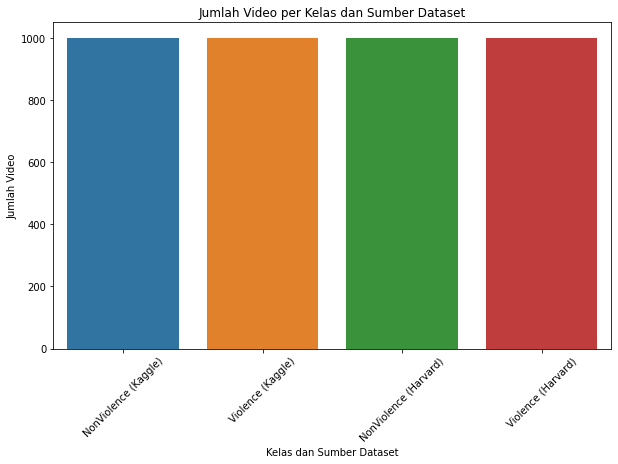

In [ ]:
video_counts = {
    "NonViolence (Kaggle)": len(NonViolence_files_names_list),
    "Violence (Kaggle)": len(Violence_files_names_list),
    "NonViolence (Harvard)": len(Harvard_NonViolence_subset),
    "Violence (Harvard)": len(Harvard_Violence_subset)
}

plt.figure(figsize=(10,6))
sns.barplot(x=list(video_counts.keys()), y=list(video_counts.values()))
plt.title("Jumlah Video per Kelas dan Sumber Dataset")
plt.ylabel("Jumlah Video")
plt.xlabel("Kelas dan Sumber Dataset")
plt.xticks(rotation=45)
plt.show()

In [ ]:
stats_table = df.groupby("class")[["duration_sec"]].describe().round(2)
display(stats_table)

duration_sec                                          
                   count  mean   std  min   25%  50%   75%     max
class                                                             
NonViolence       2000.0  5.90  4.51  1.0  5.00  5.0  6.36  179.90
Violence          2000.0  5.68  8.88  2.6  4.77  5.1  6.00  375.73

In [ ]:
file_size_stats = df.groupby("class")["file_size_MB"].describe().round(2)
display(file_size_stats)

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
NonViolence,2000.0,1.84,2.38,0.05,0.48,0.90,2.22,25.81
Violence,2000.0,2.27,2.45,0.10,0.71,1.51,2.79,30.85


In [ ]:
frame_count_stats = df.groupby("class")["frame_count"].describe().round(2)
display(frame_count_stats)

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
NonViolence,2000.0,168.69,145.10,29.0,125.0,145.0,192.0,5397.0
Violence,2000.0,169.23,266.61,62.0,132.0,154.0,185.0,11272.0


In [ ]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Play_Video(f"{KaggleNonViolenceVideos_Dir}/{Random_NonViolence_Video}")

In [ ]:
Random_Violence_Video = random.choice(Violence_files_names_list)
Play_Video(f"{KaggleViolenceVideos_Dir}/{Random_Violence_Video}")

# **Extracting Frames**

In [ ]:
def get_sampling_rate(video_path):
    """Determine sampling rate based on video duration"""
    video_reader = None
    try:
        video_reader = cv2.VideoCapture(video_path)
        if not video_reader.isOpened():
            raise IOError(f"Cannot open video file: {video_path}")

        fps = video_reader.get(cv2.CAP_PROP_FPS)
        frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0

        return 10 if duration <= 30 else 5  # 10 FPS for videos ≤30s, 5 FPS for >30s
    except Exception as e:
        print(f"Error processing {video_path}: {str(e)}", file=sys.stderr)
        return None
    finally:
        if video_reader is not None:
            video_reader.release()

In [ ]:
def get_video_frames(video_file):
    """Retrieve and process video frames with uniform sampling - Memory optimized"""
    video_capture = None
    try:
        extracted_frames = []
        video_capture = cv2.VideoCapture(video_file)

        if not video_capture.isOpened():
            raise IOError(f"Cannot open video file: {video_file}")

        # Obtain video properties
        frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
        total_video_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
        video_duration = total_video_frames / frame_rate if frame_rate > 0 else 0

        sampling_freq = get_sampling_rate(video_file)
        if sampling_freq is None:
            return None

        target_frame_count = min(int(video_duration * sampling_freq), SEQUENCE_LENGTH)

        # Calculate uniform sampling interval
        sampling_interval = max(int(total_video_frames / target_frame_count), 1)

        # Collect frames at regular intervals
        for i in range(target_frame_count):
            # Position to the appropriate frame
            video_capture.set(cv2.CAP_PROP_POS_FRAMES, i * sampling_interval)

            # Retrieve the frame
            ret, frame_data = video_capture.read()

            if not ret:
                break

            # Resize immediately to save memory
            frame_resized = cv2.resize(frame_data, (INITIAL_WIDTH, INITIAL_HEIGHT))
            # Normalize and convert to float32 (more memory efficient than float64)
            normalized_data = frame_resized.astype(np.float32) / 255.0

            extracted_frames.append(normalized_data)

            # Clear frame_data from memory
            del frame_data, frame_resized

        # Pad with zeros if needed
        if len(extracted_frames) < SEQUENCE_LENGTH:
            zero_frame = np.zeros((INITIAL_HEIGHT, INITIAL_WIDTH, 3), dtype=np.float32)
            while len(extracted_frames) < SEQUENCE_LENGTH:
                extracted_frames.append(zero_frame.copy())

        return np.array(extracted_frames, dtype=np.float32)

    except Exception as e:
        print(f"Error processing frames from {video_file}: {str(e)}", file=sys.stderr)
        return None
    finally:
        if video_capture is not None:
            video_capture.release()

In [ ]:
def augment_frame(frame, do_flip=True, do_crop=True):
    """Apply spatial augmentation to a single frame - optimized"""
    # Work with copy to avoid modifying original
    augmented_frame = frame.copy()

    # Flip
    if do_flip:
        augmented_frame = cv2.flip(augmented_frame, 1)

    # Brightness adjustment - work directly with float32
    if augmented_frame.dtype == np.float32:
        # For normalized frames (0-1 range)
        brightness_factor = 0.5 + np.random.rand() * 0.5  # 0.5 to 1.0
        augmented_frame = np.clip(augmented_frame * brightness_factor, 0, 1)
    else:
        # For uint8 frames
        brightness_factor = 0.5 + np.random.rand()
        augmented_frame = cv2.convertScaleAbs(augmented_frame, alpha=brightness_factor, beta=0)
        augmented_frame = augmented_frame.astype(np.float32) / 255.0

    # Random crop and resize
    if do_crop:
        h, w = augmented_frame.shape[:2]
        crop_size = int(min(h, w) * 0.8)
        if crop_size < min(h, w):  # Only crop if there's something to crop
            y = np.random.randint(0, h - crop_size + 1)
            x = np.random.randint(0, w - crop_size + 1)
            augmented_frame = augmented_frame[y:y + crop_size, x:x + crop_size]
            augmented_frame = cv2.resize(augmented_frame, (INITIAL_WIDTH, INITIAL_HEIGHT))

    return augmented_frame.astype(np.float32)

In [ ]:
# def temporal_augmentation(frames, seq_len):
#     """Randomly skip frames to simulate temporal variation"""
#     skip_pattern = np.random.choice([1, 2], size=len(frames), p=[0.7, 0.3])
#     selected_frames, i = [], 0
#     while i < len(frames) and len(selected_frames) < seq_len:
#         selected_frames.append(frames[i])
#         i += skip_pattern[i] if i < len(skip_pattern) else 1

#     # Pad if needed
#     pad_frame = np.zeros_like(frames[0])
#     while len(selected_frames) < seq_len:
#         selected_frames.append(pad_frame)

#     return selected_frames[:seq_len]

In [ ]:
def preprocess_train_frames(frames, apply_spatial=True):
    """Preprocessing pipeline without temporal augmentation"""
    # Ensure we have exactly SEQUENCE_LENGTH frames
    if len(frames) > SEQUENCE_LENGTH:
        frames = frames[:SEQUENCE_LENGTH]
    elif len(frames) < SEQUENCE_LENGTH:
        # Pad with zeros
        zero_frame = np.zeros((INITIAL_HEIGHT, INITIAL_WIDTH, 3), dtype=np.float32)
        while len(frames) < SEQUENCE_LENGTH:
            frames = np.append(frames, [zero_frame], axis=0)

    # Spatial augmentation
    if apply_spatial:
        do_flip = np.random.rand() > 0.5
        do_crop = np.random.rand() > 0.5
        processed_frames = []

        for frame in frames:
            if np.random.rand() > 0.5:  # Apply augmentation to 50% of frames
                processed_frame = augment_frame(frame, do_flip, do_crop)
            else:
                processed_frame = frame.astype(np.float32)

            # Resize to final dimensions
            if processed_frame.shape[:2] != (FINAL_HEIGHT, FINAL_WIDTH):
                processed_frame = cv2.resize(processed_frame, (FINAL_WIDTH, FINAL_HEIGHT))

            processed_frames.append(processed_frame)

        return np.array(processed_frames, dtype=np.float32)
    # else:
    #     # No augmentation - just resize to final dimensions
    #     processed_frames = []
    #     for frame in frames:
    #         processed_frame = frame.astype(np.float32)
    #         if processed_frame.shape[:2] != (FINAL_HEIGHT, FINAL_WIDTH):
    #             processed_frame = cv2.resize(processed_frame, (FINAL_WIDTH, FINAL_HEIGHT))
    #         processed_frames.append(processed_frame)

    #     return np.array(processed_frames, dtype=np.float32)
    else:
        return frames.astype(np.float32)

# **Creating the Data**

In [ ]:
def process_videos_in_batches():
    """Process videos in batches to save memory - now includes both Kaggle and Harvard datasets"""

    # First pass: collect all video paths from both datasets
    all_video_paths = []
    all_labels = []

    # Process Kaggle dataset
    for class_idx, class_label in enumerate(CLASSES_LIST):
        class_dir = os.path.join(DATASET_DIR, class_label)
        if os.path.exists(class_dir):
            video_files = [f for f in os.listdir(class_dir) if f.endswith(('.mp4', '.avi', '.mov'))]

            for video_name in video_files:
                full_video_path = os.path.join(class_dir, video_name)
                all_video_paths.append(full_video_path)
                all_labels.append(class_idx)

    # Process Harvard dataset - GUNAKAN SUBSET YANG SUDAH DIBUAT
    # NonViolence Harvard (class_idx = 0)
    for video_name in Harvard_NonViolence_subset:
        full_video_path = os.path.join(HarvardNonViolenceVideos_Dir, video_name)
        all_video_paths.append(full_video_path)
        all_labels.append(0)  # NonViolence = 0

    # Violence Harvard (class_idx = 1)
    for video_name in Harvard_Violence_subset:
        full_video_path = os.path.join(HarvardViolenceVideos_Dir, video_name)
        all_video_paths.append(full_video_path)
        all_labels.append(1)  # Violence = 1

    print(f"Found {len(all_video_paths)} videos total from both datasets")
    print(f"Expected: 4000 videos (1000 Kaggle NonViolence + 1000 Kaggle Violence + 1000 Harvard NonViolence + 1000 Harvard Violence)")

    # Process in batches and save immediately
    all_features = []
    all_processed_labels = []
    all_processed_paths = []

    total_batches = (len(all_video_paths) + BATCH_SIZE - 1) // BATCH_SIZE

    for batch_idx in range(total_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min((batch_idx + 1) * BATCH_SIZE, len(all_video_paths))

        print(f"\nProcessing batch {batch_idx + 1}/{total_batches} ({start_idx+1}-{end_idx}/{len(all_video_paths)})")

        batch_features = []
        batch_labels = []
        batch_paths = []

        batch_videos = all_video_paths[start_idx:end_idx]
        batch_video_labels = all_labels[start_idx:end_idx]

        for video_path, label in tqdm(zip(batch_videos, batch_video_labels),
                                     total=len(batch_videos),
                                     desc=f"Batch {batch_idx + 1}"):
            try:
                video_frames = get_video_frames(video_path)

                if video_frames is not None and len(video_frames) == SEQUENCE_LENGTH:
                    batch_features.append(video_frames)
                    batch_labels.append(label)
                    batch_paths.append(video_path)

            except Exception as e:
                print(f"Error processing {video_path}: {str(e)}", file=sys.stderr)
                continue

        # Add batch results to main lists
        if batch_features:
            all_features.extend(batch_features)
            all_processed_labels.extend(batch_labels)
            all_processed_paths.extend(batch_paths)

        # Clear batch data from memory
        del batch_features, batch_labels, batch_paths
        gc.collect()

        print(f"Batch {batch_idx + 1} completed. Total processed: {len(all_features)}")

    return np.array(all_features, dtype=np.float32), np.array(all_processed_labels), all_processed_paths

In [ ]:
def preprocess_test_frames(frames):
    """Only resize and normalize without augmentation"""
    processed_frames = []
    for frame in frames:
        if frame.shape[:2] != (FINAL_HEIGHT, FINAL_WIDTH):
            resized_frame = cv2.resize(frame, (FINAL_WIDTH, FINAL_HEIGHT))
        else:
            resized_frame = frame
        processed_frames.append(resized_frame.astype(np.float32))

    return np.array(processed_frames, dtype=np.float32)

In [ ]:
features, labels, video_files_paths = process_videos_in_batches()

print(f"Processed {len(features)} videos successfully")

Found 4000 videos total from both datasets
Expected: 4000 videos (1000 Kaggle NonViolence + 1000 Kaggle Violence + 1000 Harvard NonViolence + 1000 Harvard Violence)

Processing batch 1/125 (1-32/4000)


Batch 1: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s]


Batch 1 completed. Total processed: 32

Processing batch 2/125 (33-64/4000)


Batch 2: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Batch 2 completed. Total processed: 64

Processing batch 3/125 (65-96/4000)


Batch 3: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


Batch 3 completed. Total processed: 96

Processing batch 4/125 (97-128/4000)


Batch 4: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Batch 4 completed. Total processed: 128

Processing batch 5/125 (129-160/4000)


Batch 5: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Batch 5 completed. Total processed: 160

Processing batch 6/125 (161-192/4000)


Batch 6: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Batch 6 completed. Total processed: 192

Processing batch 7/125 (193-224/4000)


Batch 7: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]


Batch 7 completed. Total processed: 224

Processing batch 8/125 (225-256/4000)


Batch 8: 100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


Batch 8 completed. Total processed: 256

Processing batch 9/125 (257-288/4000)


Batch 9: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Batch 9 completed. Total processed: 288

Processing batch 10/125 (289-320/4000)


Batch 10: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]


Batch 10 completed. Total processed: 320

Processing batch 11/125 (321-352/4000)


Batch 11: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


Batch 11 completed. Total processed: 352

Processing batch 12/125 (353-384/4000)


Batch 12: 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]


Batch 12 completed. Total processed: 384

Processing batch 13/125 (385-416/4000)


Batch 13: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Batch 13 completed. Total processed: 416

Processing batch 14/125 (417-448/4000)


Batch 14: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


Batch 14 completed. Total processed: 448

Processing batch 15/125 (449-480/4000)


Batch 15: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]


Batch 15 completed. Total processed: 480

Processing batch 16/125 (481-512/4000)


Batch 16:  53%|█████▎    | 17/32 [00:08<00:12,  1.23it/s][h264 @ 0x56e33a5a5000] mb_type 104 in P slice too large at 98 31
[h264 @ 0x56e33a5a5000] error while decoding MB 98 31
[h264 @ 0x56e33a5a5000] mb_type 104 in P slice too large at 98 31
[h264 @ 0x56e33a5a5000] error while decoding MB 98 31
[h264 @ 0x56e33a5a5000] mb_type 104 in P slice too large at 98 31
[h264 @ 0x56e33a5a5000] error while decoding MB 98 31
[h264 @ 0x56e33a5a5000] mb_type 104 in P slice too large at 98 31
[h264 @ 0x56e33a5a5000] error while decoding MB 98 31
Batch 16: 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


Batch 16 completed. Total processed: 512

Processing batch 17/125 (513-544/4000)


Batch 17: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Batch 17 completed. Total processed: 544

Processing batch 18/125 (545-576/4000)


Batch 18: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


Batch 18 completed. Total processed: 576

Processing batch 19/125 (577-608/4000)


Batch 19: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Batch 19 completed. Total processed: 608

Processing batch 20/125 (609-640/4000)


Batch 20: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


Batch 20 completed. Total processed: 640

Processing batch 21/125 (641-672/4000)


Batch 21: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Batch 21 completed. Total processed: 672

Processing batch 22/125 (673-704/4000)


Batch 22: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Batch 22 completed. Total processed: 704

Processing batch 23/125 (705-736/4000)


Batch 23: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Batch 23 completed. Total processed: 736

Processing batch 24/125 (737-768/4000)


Batch 24: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Batch 24 completed. Total processed: 768

Processing batch 25/125 (769-800/4000)


Batch 25: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Batch 25 completed. Total processed: 800

Processing batch 26/125 (801-832/4000)


Batch 26: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


Batch 26 completed. Total processed: 832

Processing batch 27/125 (833-864/4000)


Batch 27: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Batch 27 completed. Total processed: 864

Processing batch 28/125 (865-896/4000)


Batch 28: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Batch 28 completed. Total processed: 896

Processing batch 29/125 (897-928/4000)


Batch 29: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


Batch 29 completed. Total processed: 928

Processing batch 30/125 (929-960/4000)


Batch 30: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Batch 30 completed. Total processed: 960

Processing batch 31/125 (961-992/4000)


Batch 31: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Batch 31 completed. Total processed: 992

Processing batch 32/125 (993-1024/4000)


Batch 32: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


Batch 32 completed. Total processed: 1024

Processing batch 33/125 (1025-1056/4000)


Batch 33: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


Batch 33 completed. Total processed: 1056

Processing batch 34/125 (1057-1088/4000)


Batch 34: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Batch 34 completed. Total processed: 1088

Processing batch 35/125 (1089-1120/4000)


Batch 35: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


Batch 35 completed. Total processed: 1120

Processing batch 36/125 (1121-1152/4000)


Batch 36: 100%|██████████| 32/32 [00:24<00:00,  1.29it/s]


Batch 36 completed. Total processed: 1152

Processing batch 37/125 (1153-1184/4000)


Batch 37: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


Batch 37 completed. Total processed: 1184

Processing batch 38/125 (1185-1216/4000)


Batch 38: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


Batch 38 completed. Total processed: 1216

Processing batch 39/125 (1217-1248/4000)


Batch 39: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


Batch 39 completed. Total processed: 1248

Processing batch 40/125 (1249-1280/4000)


Batch 40: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


Batch 40 completed. Total processed: 1280

Processing batch 41/125 (1281-1312/4000)


Batch 41: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Batch 41 completed. Total processed: 1312

Processing batch 42/125 (1313-1344/4000)


Batch 42: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


Batch 42 completed. Total processed: 1344

Processing batch 43/125 (1345-1376/4000)


Batch 43: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Batch 43 completed. Total processed: 1376

Processing batch 44/125 (1377-1408/4000)


Batch 44: 100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Batch 44 completed. Total processed: 1408

Processing batch 45/125 (1409-1440/4000)


Batch 45: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Batch 45 completed. Total processed: 1440

Processing batch 46/125 (1441-1472/4000)


Batch 46: 100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


Batch 46 completed. Total processed: 1472

Processing batch 47/125 (1473-1504/4000)


Batch 47: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Batch 47 completed. Total processed: 1504

Processing batch 48/125 (1505-1536/4000)


Batch 48: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


Batch 48 completed. Total processed: 1536

Processing batch 49/125 (1537-1568/4000)


Batch 49: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


Batch 49 completed. Total processed: 1568

Processing batch 50/125 (1569-1600/4000)


Batch 50: 100%|██████████| 32/32 [00:30<00:00,  1.07it/s]


Batch 50 completed. Total processed: 1600

Processing batch 51/125 (1601-1632/4000)


Batch 51: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s]


Batch 51 completed. Total processed: 1632

Processing batch 52/125 (1633-1664/4000)


Batch 52: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Batch 52 completed. Total processed: 1664

Processing batch 53/125 (1665-1696/4000)


Batch 53: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


Batch 53 completed. Total processed: 1696

Processing batch 54/125 (1697-1728/4000)


Batch 54: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]


Batch 54 completed. Total processed: 1728

Processing batch 55/125 (1729-1760/4000)


Batch 55: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


Batch 55 completed. Total processed: 1760

Processing batch 56/125 (1761-1792/4000)


Batch 56: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


Batch 56 completed. Total processed: 1792

Processing batch 57/125 (1793-1824/4000)


Batch 57: 100%|██████████| 32/32 [00:25<00:00,  1.28it/s]


Batch 57 completed. Total processed: 1824

Processing batch 58/125 (1825-1856/4000)


Batch 58: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


Batch 58 completed. Total processed: 1856

Processing batch 59/125 (1857-1888/4000)


Batch 59: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Batch 59 completed. Total processed: 1888

Processing batch 60/125 (1889-1920/4000)


Batch 60: 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


Batch 60 completed. Total processed: 1920

Processing batch 61/125 (1921-1952/4000)


Batch 61: 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


Batch 61 completed. Total processed: 1952

Processing batch 62/125 (1953-1984/4000)


Batch 62: 100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Batch 62 completed. Total processed: 1984

Processing batch 63/125 (1985-2016/4000)


Batch 63: 100%|██████████| 32/32 [01:15<00:00,  2.36s/it]


Batch 63 completed. Total processed: 2016

Processing batch 64/125 (2017-2048/4000)


Batch 64: 100%|██████████| 32/32 [02:44<00:00,  5.14s/it]


Batch 64 completed. Total processed: 2048

Processing batch 65/125 (2049-2080/4000)


Batch 65: 100%|██████████| 32/32 [02:45<00:00,  5.18s/it]


Batch 65 completed. Total processed: 2080

Processing batch 66/125 (2081-2112/4000)


Batch 66: 100%|██████████| 32/32 [02:41<00:00,  5.05s/it]


Batch 66 completed. Total processed: 2112

Processing batch 67/125 (2113-2144/4000)


Batch 67: 100%|██████████| 32/32 [02:05<00:00,  3.92s/it]


Batch 67 completed. Total processed: 2144

Processing batch 68/125 (2145-2176/4000)


Batch 68: 100%|██████████| 32/32 [02:39<00:00,  4.98s/it]


Batch 68 completed. Total processed: 2176

Processing batch 69/125 (2177-2208/4000)


Batch 69: 100%|██████████| 32/32 [02:12<00:00,  4.15s/it]


Batch 69 completed. Total processed: 2208

Processing batch 70/125 (2209-2240/4000)


Batch 70: 100%|██████████| 32/32 [02:50<00:00,  5.33s/it]


Batch 70 completed. Total processed: 2240

Processing batch 71/125 (2241-2272/4000)


Batch 71: 100%|██████████| 32/32 [02:53<00:00,  5.43s/it]


Batch 71 completed. Total processed: 2272

Processing batch 72/125 (2273-2304/4000)


Batch 72: 100%|██████████| 32/32 [02:07<00:00,  3.97s/it]


Batch 72 completed. Total processed: 2304

Processing batch 73/125 (2305-2336/4000)


Batch 73: 100%|██████████| 32/32 [03:00<00:00,  5.63s/it]


Batch 73 completed. Total processed: 2336

Processing batch 74/125 (2337-2368/4000)


Batch 74: 100%|██████████| 32/32 [02:05<00:00,  3.93s/it]


Batch 74 completed. Total processed: 2368

Processing batch 75/125 (2369-2400/4000)


Batch 75: 100%|██████████| 32/32 [02:56<00:00,  5.51s/it]


Batch 75 completed. Total processed: 2400

Processing batch 76/125 (2401-2432/4000)


Batch 76: 100%|██████████| 32/32 [03:18<00:00,  6.20s/it]


Batch 76 completed. Total processed: 2432

Processing batch 77/125 (2433-2464/4000)


Batch 77: 100%|██████████| 32/32 [02:39<00:00,  5.00s/it]


Batch 77 completed. Total processed: 2464

Processing batch 78/125 (2465-2496/4000)


Batch 78: 100%|██████████| 32/32 [02:37<00:00,  4.91s/it]


Batch 78 completed. Total processed: 2496

Processing batch 79/125 (2497-2528/4000)


Batch 79: 100%|██████████| 32/32 [02:29<00:00,  4.66s/it]


Batch 79 completed. Total processed: 2528

Processing batch 80/125 (2529-2560/4000)


Batch 80: 100%|██████████| 32/32 [02:56<00:00,  5.52s/it]


Batch 80 completed. Total processed: 2560

Processing batch 81/125 (2561-2592/4000)


Batch 81: 100%|██████████| 32/32 [02:34<00:00,  4.84s/it]


Batch 81 completed. Total processed: 2592

Processing batch 82/125 (2593-2624/4000)


Batch 82: 100%|██████████| 32/32 [02:54<00:00,  5.47s/it]


Batch 82 completed. Total processed: 2624

Processing batch 83/125 (2625-2656/4000)


Batch 83: 100%|██████████| 32/32 [02:07<00:00,  3.98s/it]


Batch 83 completed. Total processed: 2656

Processing batch 84/125 (2657-2688/4000)


Batch 84: 100%|██████████| 32/32 [02:31<00:00,  4.73s/it]


Batch 84 completed. Total processed: 2688

Processing batch 85/125 (2689-2720/4000)


Batch 85: 100%|██████████| 32/32 [02:15<00:00,  4.24s/it]


Batch 85 completed. Total processed: 2720

Processing batch 86/125 (2721-2752/4000)


Batch 86: 100%|██████████| 32/32 [02:26<00:00,  4.59s/it]


Batch 86 completed. Total processed: 2752

Processing batch 87/125 (2753-2784/4000)


Batch 87: 100%|██████████| 32/32 [02:37<00:00,  4.92s/it]


Batch 87 completed. Total processed: 2784

Processing batch 88/125 (2785-2816/4000)


Batch 88: 100%|██████████| 32/32 [02:38<00:00,  4.95s/it]


Batch 88 completed. Total processed: 2816

Processing batch 89/125 (2817-2848/4000)


Batch 89: 100%|██████████| 32/32 [02:29<00:00,  4.66s/it]


Batch 89 completed. Total processed: 2848

Processing batch 90/125 (2849-2880/4000)


Batch 90: 100%|██████████| 32/32 [03:02<00:00,  5.70s/it]


Batch 90 completed. Total processed: 2880

Processing batch 91/125 (2881-2912/4000)


Batch 91: 100%|██████████| 32/32 [02:57<00:00,  5.55s/it]


Batch 91 completed. Total processed: 2912

Processing batch 92/125 (2913-2944/4000)


Batch 92: 100%|██████████| 32/32 [02:26<00:00,  4.57s/it]


Batch 92 completed. Total processed: 2944

Processing batch 93/125 (2945-2976/4000)


Batch 93: 100%|██████████| 32/32 [02:17<00:00,  4.31s/it]


Batch 93 completed. Total processed: 2976

Processing batch 94/125 (2977-3008/4000)


Batch 94: 100%|██████████| 32/32 [02:27<00:00,  4.62s/it]


Batch 94 completed. Total processed: 3008

Processing batch 95/125 (3009-3040/4000)


Batch 95: 100%|██████████| 32/32 [03:02<00:00,  5.71s/it]


Batch 95 completed. Total processed: 3040

Processing batch 96/125 (3041-3072/4000)


Batch 96: 100%|██████████| 32/32 [03:19<00:00,  6.23s/it]


Batch 96 completed. Total processed: 3072

Processing batch 97/125 (3073-3104/4000)


Batch 97: 100%|██████████| 32/32 [03:40<00:00,  6.89s/it]


Batch 97 completed. Total processed: 3104

Processing batch 98/125 (3105-3136/4000)


Batch 98: 100%|██████████| 32/32 [02:49<00:00,  5.29s/it]


Batch 98 completed. Total processed: 3136

Processing batch 99/125 (3137-3168/4000)


Batch 99: 100%|██████████| 32/32 [03:08<00:00,  5.88s/it]


Batch 99 completed. Total processed: 3168

Processing batch 100/125 (3169-3200/4000)


Batch 100: 100%|██████████| 32/32 [03:09<00:00,  5.91s/it]


Batch 100 completed. Total processed: 3200

Processing batch 101/125 (3201-3232/4000)


Batch 101: 100%|██████████| 32/32 [03:13<00:00,  6.05s/it]


Batch 101 completed. Total processed: 3232

Processing batch 102/125 (3233-3264/4000)


Batch 102: 100%|██████████| 32/32 [03:07<00:00,  5.86s/it]


Batch 102 completed. Total processed: 3264

Processing batch 103/125 (3265-3296/4000)


Batch 103: 100%|██████████| 32/32 [02:55<00:00,  5.50s/it]


Batch 103 completed. Total processed: 3296

Processing batch 104/125 (3297-3328/4000)


Batch 104: 100%|██████████| 32/32 [02:58<00:00,  5.58s/it]


Batch 104 completed. Total processed: 3328

Processing batch 105/125 (3329-3360/4000)


Batch 105: 100%|██████████| 32/32 [03:21<00:00,  6.30s/it]


Batch 105 completed. Total processed: 3360

Processing batch 106/125 (3361-3392/4000)


Batch 106: 100%|██████████| 32/32 [02:49<00:00,  5.31s/it]


Batch 106 completed. Total processed: 3392

Processing batch 107/125 (3393-3424/4000)


Batch 107: 100%|██████████| 32/32 [02:54<00:00,  5.45s/it]


Batch 107 completed. Total processed: 3424

Processing batch 108/125 (3425-3456/4000)


Batch 108: 100%|██████████| 32/32 [03:24<00:00,  6.39s/it]


Batch 108 completed. Total processed: 3456

Processing batch 109/125 (3457-3488/4000)


Batch 109: 100%|██████████| 32/32 [03:09<00:00,  5.92s/it]


Batch 109 completed. Total processed: 3488

Processing batch 110/125 (3489-3520/4000)


Batch 110: 100%|██████████| 32/32 [03:29<00:00,  6.54s/it]


Batch 110 completed. Total processed: 3520

Processing batch 111/125 (3521-3552/4000)


Batch 111: 100%|██████████| 32/32 [02:56<00:00,  5.51s/it]


Batch 111 completed. Total processed: 3552

Processing batch 112/125 (3553-3584/4000)


Batch 112: 100%|██████████| 32/32 [03:13<00:00,  6.04s/it]


Batch 112 completed. Total processed: 3584

Processing batch 113/125 (3585-3616/4000)


Batch 113: 100%|██████████| 32/32 [02:50<00:00,  5.34s/it]


Batch 113 completed. Total processed: 3616

Processing batch 114/125 (3617-3648/4000)


Batch 114: 100%|██████████| 32/32 [03:14<00:00,  6.08s/it]


Batch 114 completed. Total processed: 3648

Processing batch 115/125 (3649-3680/4000)


Batch 115: 100%|██████████| 32/32 [02:51<00:00,  5.35s/it]


Batch 115 completed. Total processed: 3680

Processing batch 116/125 (3681-3712/4000)


Batch 116: 100%|██████████| 32/32 [03:03<00:00,  5.73s/it]


Batch 116 completed. Total processed: 3712

Processing batch 117/125 (3713-3744/4000)


Batch 117: 100%|██████████| 32/32 [02:54<00:00,  5.45s/it]


Batch 117 completed. Total processed: 3744

Processing batch 118/125 (3745-3776/4000)


Batch 118: 100%|██████████| 32/32 [02:56<00:00,  5.51s/it]


Batch 118 completed. Total processed: 3776

Processing batch 119/125 (3777-3808/4000)


Batch 119: 100%|██████████| 32/32 [02:59<00:00,  5.60s/it]


Batch 119 completed. Total processed: 3808

Processing batch 120/125 (3809-3840/4000)


Batch 120: 100%|██████████| 32/32 [03:05<00:00,  5.81s/it]


Batch 120 completed. Total processed: 3840

Processing batch 121/125 (3841-3872/4000)


Batch 121: 100%|██████████| 32/32 [03:11<00:00,  5.99s/it]


Batch 121 completed. Total processed: 3872

Processing batch 122/125 (3873-3904/4000)


Batch 122: 100%|██████████| 32/32 [03:01<00:00,  5.66s/it]


Batch 122 completed. Total processed: 3904

Processing batch 123/125 (3905-3936/4000)


Batch 123: 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


Batch 123 completed. Total processed: 3936

Processing batch 124/125 (3937-3968/4000)


Batch 124: 100%|██████████| 32/32 [02:53<00:00,  5.41s/it]


Batch 124 completed. Total processed: 3968

Processing batch 125/125 (3969-4000/4000)


Batch 125: 100%|██████████| 32/32 [03:14<00:00,  6.07s/it]


Batch 125 completed. Total processed: 4000
Processed 4000 videos successfully


In [ ]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [ ]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

# **Encoding and Splitting Training-Testing Sets**

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train (90%) and Test Set (10%)
train_indices, test_indices = train_test_split(
    range(len(features)), test_size=0.2, shuffle=True, random_state=42
)


In [ ]:
features_train = []
for i in tqdm(train_indices, desc="Processing train data"):
    processed_seq = preprocess_train_frames(features[i], apply_spatial=True)
    features_train.append(processed_seq)

features_train = np.array(features_train, dtype=np.float32)

Processing train data: 100%|██████████| 3200/3200 [00:09<00:00, 331.58it/s]


In [ ]:
features_test = []
for i in tqdm(test_indices, desc="Processing test data"):
    processed_seq = preprocess_test_frames(features[i])
    features_test.append(processed_seq)

features_test = np.array(features_test, dtype=np.float32)

labels_train = one_hot_encoded_labels[train_indices]
labels_test = one_hot_encoded_labels[test_indices]

Processing test data: 100%|██████████| 800/800 [00:01<00:00, 483.15it/s]


In [ ]:
# Saving the extracted data
np.save("features_train.npy", features_train)
np.save("features_test.npy", features_test)
np.save("labels_train.npy", labels_train)
np.save("labels_test.npy", labels_test)
np.save("test_indices.npy", test_indices)
np.save("video_files_paths.npy",video_files_paths)

In [ ]:
features_train = np.load("features_train.npy", allow_pickle=True)
features_test = np.load("features_test.npy", allow_pickle=True)
labels_train = np.load("labels_train.npy", allow_pickle=True)
labels_test = np.load("labels_test.npy", allow_pickle=True)
video_files_paths = np.load("video_files_paths.npy", allow_pickle=True)

In [ ]:
print(f"Training data shape: {features_train.shape}, {labels_train.shape}")
print(f"Test data shape: {features_test.shape}, {labels_test.shape}")

Training data shape: (3200, 16, 112, 112, 3), (3200, 2)
Test data shape: (800, 16, 112, 112, 3), (800, 2)


In [ ]:
# del features, features_train, features_test
# gc.collect()

27296

In [ ]:
# Count class distribution in training set
unique_train, counts_train = np.unique(labels_train, return_counts=True)
train_nonviolence = counts_train[0] if 0 in unique_train else 0
train_violence = counts_train[1] if 1 in unique_train else 0

print(f"\nTraining Set Distribution:")
print(f"  NonViolence (0): {train_nonviolence} videos")
print(f"  Violence (1): {train_violence} videos")
print(f"  Total: {len(labels_train)} videos")
print(f"  Ratio NonViolence:Violence = {train_nonviolence}:{train_violence}")

# Count class distribution in test set
unique_test, counts_test = np.unique(labels_test, return_counts=True)
test_nonviolence = counts_test[0] if 0 in unique_test else 0
test_violence = counts_test[1] if 1 in unique_test else 0

print(f"\nTest Set Distribution:")
print(f"  NonViolence (0): {test_nonviolence} videos")
print(f"  Violence (1): {test_violence} videos")
print(f"  Total: {len(labels_test)} videos")
print(f"  Ratio NonViolence:Violence = {test_nonviolence}:{test_violence}")

# Overall distribution
total_nonviolence = train_nonviolence + test_nonviolence
total_violence = train_violence + test_violence
total_videos = len(labels_train) + len(labels_test)

print(f"\nOverall Distribution:")
print(f"  Total NonViolence: {total_nonviolence} videos")
print(f"  Total Violence: {total_violence} videos")
print(f"  Total Videos: {total_videos} videos")
print(f"  Overall Ratio NonViolence:Violence = {total_nonviolence}:{total_violence}")


Training Set Distribution:
  NonViolence (0): 3200 videos
  Violence (1): 3200 videos
  Total: 3200 videos
  Ratio NonViolence:Violence = 3200:3200

Test Set Distribution:
  NonViolence (0): 800 videos
  Violence (1): 800 videos
  Total: 800 videos
  Ratio NonViolence:Violence = 800:800

Overall Distribution:
  Total NonViolence: 4000 videos
  Total Violence: 4000 videos
  Total Videos: 4000 videos
  Overall Ratio NonViolence:Violence = 4000:4000
